Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

problem1-reg_data.csv – данные о времени регистрации

problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

### Изучим исходные данные

In [1]:
import pandas as pd

In [2]:
regs = pd.read_csv('problem1-reg_data.csv', sep = ';')
visits = pd.read_csv('problem1-auth_data.csv', sep = ';')

In [3]:
regs.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
regs.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
visits.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
visits.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [7]:
visits.dtypes

auth_ts    int64
uid        int64
dtype: object

In [8]:
regs.dtypes

reg_ts    int64
uid       int64
dtype: object

### Функция для расчета retention игроков

In [9]:
def retention_by_cohort(path_reg, path_auth):
    
    import pandas as pd
    import datetime
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(20,16))

    regs = pd.read_csv(path_reg, sep=';')
    visits = pd.read_csv(path_auth, sep=';')

    # приводим даты в удобный формат
    regs['reg_ts'] = pd.to_datetime(regs.reg_ts, unit='s').dt.date 
    visits['auth_ts'] = pd.to_datetime(visits.auth_ts, unit='s').dt.date

    # для проверки функции ограничимся одним месяцем
    reg_test = regs.query('reg_ts >= datetime.date(2020,1,1)')
    visits_test = visits.query('auth_ts < datetime.date(2020,2,1)')

    # объединим все данные в один датафрейм
    regs_and_auths = pd.merge(visits_test, reg_test, on='uid')

    # вычисляем разницу дат
    regs_and_auths['visit_days'] = (regs_and_auths['auth_ts'] - regs_and_auths['reg_ts']).dt.days 

    # формируем когорты пользователей
    cohorts_df = regs_and_auths.groupby(['reg_ts', 'visit_days'], as_index=False)['uid'].nunique()

    cohorts = cohorts_df.pivot(index='reg_ts', columns='visit_days', values='uid')

    day_total_auths = cohorts[0] #  количество пользователей в день
    retention = cohorts.divide(day_total_auths, axis=0)

    # красочная обертка
    ax = sns.heatmap(data=retention, annot=True, fmt='.1%', vmin=0.0, vmax=0.12,
                     cmap= 'coolwarm', linewidths=0.5, linecolor='black')
    plt.title('User retention by cohort')
    ax.set_xlabel('Retention N-ного дня')
    ax.set_ylabel('Когорта')

    fig = ax.get_figure()

    plt.show()

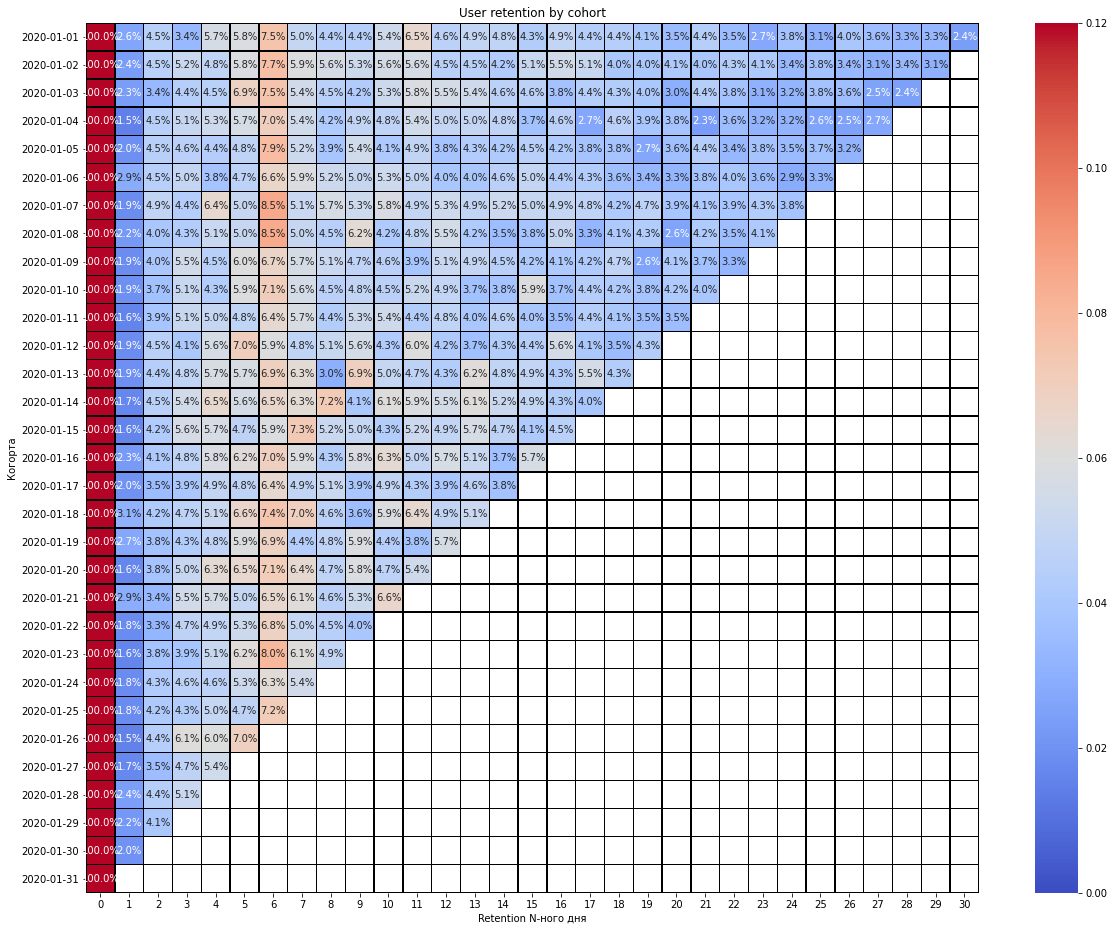

In [10]:
path_reg = 'problem1-reg_data.csv'
path_auth = 'problem1-auth_data.csv'
retention_data = retention_by_cohort(path_reg, path_auth)

## Задание №2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [11]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import norm
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from statsmodels.stats.proportion import proportions_ztest

In [12]:
df = pd.read_csv('problem2.csv', sep=';')

In [13]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [15]:
# подготовим данные и соберем полученную информацию в таблицу для наглядности

control = df.query('testgroup == "a"')
test = df.query('testgroup == "b"')

# количество пользователей в группах
users_quantity_control = control.shape[0]
users_quantity_test = test.shape[0]

# выручка
total_revenue_control =  control.revenue.sum()
total_revenue_test =  test.revenue.sum()

# количество покупок в группах
checks_control_quantity = control.query('revenue > 0').shape[0]
checks_test_quantity = test.query('revenue > 0').shape[0]

# количество клиентов в группах
clients_control_quantity = control.query('revenue > 0').user_id.nunique()
clients_test_quantity = test.query('revenue > 0').user_id.nunique()
    
# конверсия в покупателя
cr_control = round(clients_control_quantity / control.shape[0] * 100, 2)
cr_test = round(clients_test_quantity / control.shape[0] * 100 ,2)
         
# ARPU
arpu_control = round(control.revenue.sum() / control.shape[0], 2)
arpu_test = round(test.revenue.sum() / test.shape[0], 2)

# ARPPU
arppu_control = round(control.revenue.sum() / clients_control_quantity, 2)
arppu_test = round(test.revenue.sum() / clients_test_quantity, 2)
    
# коэффициент повторных покупок
rep_purch_control = round(checks_control_quantity / clients_control_quantity, 2)
rep_purch_test = round(checks_test_quantity / clients_test_quantity, 2)

metrics = pd.DataFrame({'group': ["control", "test"],
                   'users': [users_quantity_control, users_quantity_test],
                   'clients': [clients_control_quantity, clients_test_quantity],
                   'total_revenue': [total_revenue_control, total_revenue_test],
                   'CR': [cr_control, cr_test],
                   'arpu': [arpu_control, arpu_test],
                   'arppu': [arppu_control, arppu_test],
                   'rep_purch': [rep_purch_control, rep_purch_test]}
                 )

metrics = metrics.set_index("group").T

metrics['diff'] = metrics['test'] - metrics['control']
metrics['percent_diff'] = round(metrics['diff'] / metrics['control'] * 100, 2)
metrics

group,control,test,diff,percent_diff
users,202103.00,202667.00,564.00,0.28
clients,1928.00,1805.00,-123.00,-6.38
total_revenue,5136189.00,5421603.00,285414.00,5.56
CR,0.95,0.89,-0.06,-6.32
arpu,25.41,26.75,1.34,5.27
arppu,2664.00,3003.66,339.66,12.75
rep_purch,1.00,1.00,0.00,0.00


Рассчитаем стандартное отклонение "revenue":

In [16]:
np.std(control.query('revenue > 0').revenue)

9046.69271636053

In [17]:
np.std(test.query('revenue > 0').revenue)

572.461066956649

Стандартное отклонение "revenue" контрольной группы многократно превышает sd тестовой, можно судить о большей волатильности платежей в контрольной группе. Std можно также включить в набор метрик для принятия решений. 
Например, меньше волатильность - большая предсказуемость ожидаемого результата, большая репрезентативность других метрик (средний чек и т.д.) # ??

Проверим распределения величин "revenue" в контрольной и тестовой группах.

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)


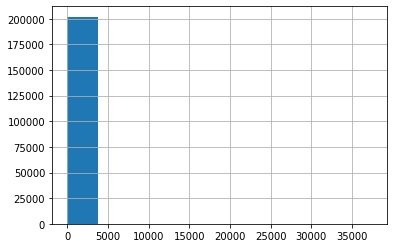

In [18]:
control.revenue.hist()
print(stats.shapiro(control.revenue.sample(1000, random_state=17)))

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)


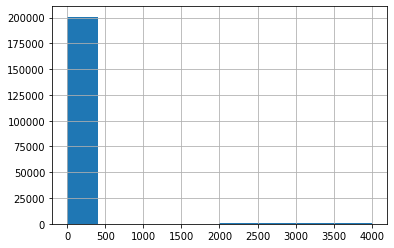

In [19]:
test.revenue.hist()
print(stats.shapiro(test.revenue.sample(1000, random_state=17)))

Тест Шапиро-Уилка подтверждает, что распределения "revenue" контрольной и тестовых групп не являются нормальными. 
Следовательно, для сравнения групп будем ипользовать бутстрэп. Но сначала рассмотрим их более детально.

array([  311.  , 37299.65, 37340.73])

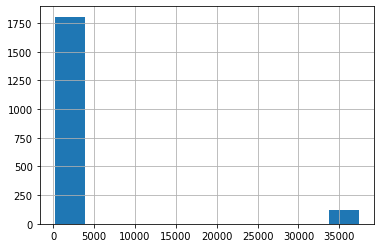

In [20]:
control.query('revenue != 0').revenue.hist()
np.percentile(control.query('revenue != 0').revenue, [50, 95, 99])

array([305., 391., 398.])

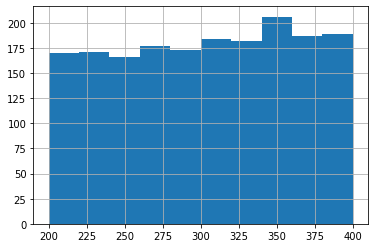

In [21]:
control.query('revenue != 0 and revenue < 37000').revenue.hist()
np.percentile(control.query('revenue != 0 and revenue < 37000').revenue, [50, 95, 99])

In [22]:
control.query('revenue > 37000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


array([37311.  , 37368.7 , 37404.14])

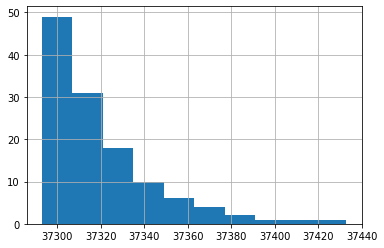

In [23]:
control.query('revenue > 37000').revenue.hist()
np.percentile(control.query('revenue > 37000').revenue, [50, 95, 99])

In [24]:
print(round(control.query('revenue > 37000').shape[0] / clients_control_quantity * 100, 2))

6.38


In [25]:
round(control.query('revenue > 37000').revenue.sum() / total_revenue_control * 100, 2)

89.37

### В контрольной группе 6.38% клиентов (123 клиента) с наибольшими чеками (от 37324) обеспечивают 89.37% процентов выручки.
Остальные 1805 клиентов генерируют оставшиеся 10.63%, величины их транзакции распределены между значениями 200 и 400.
Таким образом контрольная группа делится на 2 неравные подгруппы. 

array([3022.  , 3891.8 , 3981.92])

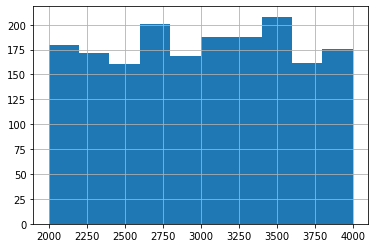

In [26]:
test.query('revenue != 0').revenue.hist()
np.percentile(test.query('revenue != 0').revenue, [50, 95, 99])

### В первой тестовой группе ситуация обстоит совершенно по-другому: все транзакции клиентов распределены между 2000 и 4000.

Учитывая, такую большую разницу в стандартном отклонении, можно попробовать сравнить логарифмы "revenue", а также проверить стат.значимость критерием Манна-Уитни:

#### ARPU:

In [27]:
mannwhitneyu(test.revenue,
             control.revenue)

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.03134850658037196)

#### ARRPU:

In [28]:
mannwhitneyu(test.query('revenue > 0').revenue,
             control.query('revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Значения коэффициентов конверсии, ARPU и ARPPU в группах стат.значимо различаются.

#### CR:

In [29]:
# для этой цели воспользуемся proportions_ztest (!может меня кто-то поправит, я не уверен, что он в полной мере подходит!)
count = np.array([control.query('revenue > 0').user_id.nunique(), test.query('revenue > 0').user_id.nunique()])
nobs = np.array([control.user_id.nunique(), test.user_id.nunique()])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = 2.108028495889841 
 p-value = 0.035028524642854865


### Итог:

In [30]:
metrics

group,control,test,diff,percent_diff
users,202103.00,202667.00,564.00,0.28
clients,1928.00,1805.00,-123.00,-6.38
total_revenue,5136189.00,5421603.00,285414.00,5.56
CR,0.95,0.89,-0.06,-6.32
arpu,25.41,26.75,1.34,5.27
arppu,2664.00,3003.66,339.66,12.75
rep_purch,1.00,1.00,0.00,0.00


Конверсия в покупку, ARPU и ARPPU статистически значимо различаются в контрольной и тестовых группах. CR на 6.32% выше в контрольной, ARPU и ARPPU напротив выше в тестовой, на 5.27% и 12.75% соответственно. 
Суммарная выручка в тестовой группе больше (на 5.56%).

Набор предложений тестовой группы можно считать лучшим: больше суммарная выручка, лучшие показатели ARPU и ARPPU - при меньшей конверсии. При этом стандартное отклонение распределения "revenue" в тестовой группе многократно меньше, что потенциально может облегчить анализ метрик и обеспечить лучшую прогнозируемость. Поэтому Standart Deviation можно также включить в набор метрик для принятия решений.

Набор метрик: суммарная выручка, ARPU, ARPPU, CR, Standart Deviation.

 
## Задание №3 
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время.

С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Ответ:

1. Одной из основных целей проведения тематических событий и введения различных механик, вроде раздачи дополнительных бонусов, уникальных предметов в определенные временные промежутки является увеличение числа и продолжительности игровых сессий и Retention Rate, и уже посредством этого улyчшение финансовых показателей и других метрик, таких как ARPU / ARPPU / DAU и т.д. 

    Основные метрики:
    - Average Session Duration - среднее время игровых сессий за период времени;
    - Retention rate (RR);
    - ARPU / ARPPU / Average Transaction Value (средняя стоимость покупок за период);
    - DAU / WAU / MAU; 
    - CR в плательщика.


2. Набор метрик в целом останется прежним, но, возможно, после нововведения стоило бы обратить особое внимание на изменение 
    - ASL - заставит ли это игрока больше времени проводить в игре;
    - Churn Rate (или RR) - не пропадет ли интерес к игре после усложнения механики или, наоборот, возрастет
